In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os, glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from transformers import Dinov2Model



/Users/k.choi/opt/miniconda3/envs/pytorch_csiro/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_dir = '/Users/k.choi/Documents/github/csiro_git'
# project_dir = '/Users/kaheichoi/git_repo/csiro_biomass'
data_dir  = os.path.join(project_dir, 'data')
model_dir = os.path.join(project_dir, 'models')

train_csv = pd.read_csv(os.path.join(data_dir, 'train.csv'))
device    = torch.device('mps')

In [3]:
unique_paths  = train_csv['image_path'].unique(); print(unique_paths.shape)

(357,)


In [4]:
train_csv['target_name'].unique()

array(['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g',
       'GDM_g'], dtype=object)

In [5]:
def data_preprocess(df, data_dir):
    data_list = []
    
    unique_paths = df['image_path'].unique()
    target_names = df['target_name'].unique()

    for paths in unique_paths:
        data = df[ df['image_path'] == paths ]
        row = { 'image_path': paths }
        for tar in target_names:
            row[tar] = data[ data['target_name'] == tar ]['target'].values[0]
        
        data_list.append(row)

    return pd.DataFrame(data_list)

data_df = data_preprocess(train_csv, data_dir); display(data_df)


,image_path,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,train/ID1011485656.jpg,0.0000,31.9984,16.2751,48.2735,16.2750
1,train/ID1012260530.jpg,0.0000,0.0000,7.6000,7.6000,7.6000
2,train/ID1025234388.jpg,6.0500,0.0000,0.0000,6.0500,6.0500
3,train/ID1028611175.jpg,0.0000,30.9703,24.2376,55.2079,24.2376
4,train/ID1035947949.jpg,0.4343,23.2239,10.5261,34.1844,10.9605
...,...,...,...,...,...,...
352,train/ID975115267.jpg,40.0300,0.0000,0.8000,40.8300,40.8300
353,train/ID978026131.jpg,24.6445,4.1948,12.0601,40.8994,36.7046
354,train/ID980538882.jpg,0.0000,1.1457,91.6543,92.8000,91.6543
355,train/ID980878870.jpg,32.3575,0.0000,2.0325,34.3900,34.3900


In [6]:
train_data, test_data  = train_test_split(data_df, test_size=0.01, random_state=8964); print(f'train: {len(train_data)}, test: {len(test_data)}')

train: 353, test: 4


In [7]:
def create_stratified_folds(df, target_col='Dry_Total_g', n_folds=5, random_state=8964):
    strata_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
 
    bins = [0, 20, 40, 60, 80, np.inf]
    dfcopy = df.copy()
    dfcopy['strata'] = pd.cut(dfcopy[target_col], bins=bins, labels=False) 
    
    kfolds = []
    for train_idx, val_idx in strata_kfold.split(dfcopy, dfcopy['strata']):
        kfolds.append((train_idx, val_idx))
    
    return kfolds

kfolds  = create_stratified_folds(train_data, target_col='Dry_Total_g', n_folds=5)

for i, (train_idx, val_idx) in enumerate(kfolds): 
    print(f"Fold {i+1}: {len(train_idx)} train, {len(val_idx)} val")
    assert len(train_idx) + len(val_idx) == len(train_data)

Fold 1: 282 train, 71 val
Fold 2: 282 train, 71 val
Fold 3: 282 train, 71 val
Fold 4: 283 train, 70 val
Fold 5: 283 train, 70 val


In [8]:
class tta:

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std 

    def get_transforms(self):
        return [
            ( 'id',     self.__get_id()),
            ( 'hflip',  self.__get_hflip()),
            ( 'vflip',  self.__get_vflip()),
            ( 'rot90',  self.__get_rota(90)),
            ( 'rot180', self.__get_rota(180)),
            ( 'rot270', self.__get_rota(270)) ]

    def __get_id(self):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std) ])

    def __get_hflip(self):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomHorizontalFlip(p=1),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std) ])

    def __get_vflip(self):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomVerticalFlip(p=1),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std) ])
        
    def __get_rota(self,angle):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.Lambda(lambda img: transforms.functional.rotate(img, angle)),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std) ])
         

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]  

tta_transforms = tta(mean=mean, std=std)
tta_list = tta_transforms.get_transforms()

for names, _ in tta_list: print(names)

id
hflip
vflip
rot90
rot180
rot270


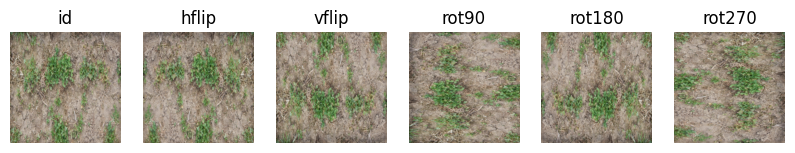

In [9]:
img_path = os.path.join( data_dir, np.random.choice(unique_paths)) 

fig,axes = plt.subplots(1,6, figsize=(10,3))
for i, (name, transform) in enumerate(tta_list):
    img = Image.open(img_path)
    img = transform(img)
    
    mean = torch.tensor( [0.485, 0.456, 0.406] ).view(3,1,1)
    std  = torch.tensor( [0.229, 0.224, 0.225] ).view(3,1,1)

    img  = img * std + mean
    img  = torch.clamp(img,0,1)
    img  = img.permute(1,2,0).numpy()

    axes[i].imshow(img)
    axes[i].set_title(name)
    axes[i].axis('off')

plt.show()

In [10]:
class BiomassDS(Dataset):
    def __init__(self, df, data_dir, transform, target_names = ['Dry_Clover_g','Dry_Dead_g', 'Dry_Green_g','Dry_Total_g','GDM_g']):
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform
        self.target_names = target_names

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.data_dir, row['image_path'])
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        targets = torch.tensor( [row[col] for col in self.target_names], dtype=torch.float32)
        return img, targets

In [11]:
class call_my_dino(nn.Module):
    def __init__(self, backbone, patch_dim, n_targets):
        super().__init__()
        
        self.backbone = backbone
        for params in self.backbone.parameters():
            params.requires_grad = False

        self.dino_head = nn.Sequential(
            nn.Linear(patch_dim, 512),
            nn.LayerNorm(512),  
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LayerNorm(256),  
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(256, n_targets),
        )

    def forward(self, x):
        with torch.no_grad():
            outputs = self.backbone(x)
            patch_features = outputs.last_hidden_state[:, 1:, :]

        batch_size, n_patches, patch_dim = patch_features.shape
        patch_features_flat = patch_features.reshape(-1, patch_dim)
        patch_pred = self.dino_head(patch_features_flat)
        patch_pred = patch_pred.reshape(batch_size, n_patches, -1)

        final_pred = torch.mean(patch_pred, dim=1)

        return final_pred, patch_pred

In [12]:
small_dinov2_backbone = Dinov2Model.from_pretrained('facebook/dinov2-small');
small_dinov2_backbone.eval();
small_dinov2_backbone.to(device);

In [ ]:
nfolds = 5
batch_size = 16


fold_preds = []
for fold_idx in range(nfolds):
    print(f'Fold {fold_idx}')
    print(32 * '= ')
    best_model_path = os.path.join(model_dir, f'best_model_fold_{fold_idx}.pth')
    model           = call_my_dino(small_dinov2_backbone, patch_dim=384, n_targets=5)

    model.load_state_dict(torch.load(best_model_path))
    model.to(device)

    tta_list = tta_transforms.get_transforms()
    all_preds = [] 
    for  tta_idx, (tta_name, transform) in enumerate(tta_list):
        model.eval()

        tta_dataset = BiomassDS(test_data, data_dir, transform)
        tta_loader  = DataLoader(tta_dataset, batch_size=batch_size, shuffle=False)

        fold_tta_pred = []

        with torch.no_grad():
            pbar = tqdm(tta_loader, desc=f'Fold {fold_idx} TTA {tta_name}')
            for img, _ in tta_loader:
                img     = img.to(device)
                pred, _ = model(img)
                fold_tta_pred.append(pred.cpu().numpy()) 

        all_preds.append( fold_tta_pred [0])

    mean_pred = np.mean(np.array(all_preds), axis=0)
    fold_preds.append(mean_pred)



averged_pred = np.mean(np.array(fold_preds), axis=0)

targ_list = [] 
for _, tar in tta_loader:
    targ_list.append(tar.cpu().numpy())

targ_list = np.array(targ_list[0])

Fold 0
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


Fold 0 TTA rot180:   0%|          | 0/1 [00:00<?, ?it/s]


Fold 1
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


Fold 1 TTA rot180:   0%|          | 0/1 [00:00<?, ?it/s]


Fold 2
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


Fold 2 TTA rot180:   0%|          | 0/1 [00:00<?, ?it/s]


Fold 3
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


Fold 3 TTA rot180:   0%|          | 0/1 [00:00<?, ?it/s]


Fold 4
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


Fold 4 TTA rot180:   0%|          | 0/1 [00:00<?, ?it/s]


In [17]:
averged_pred.shape

(4, 5)

In [18]:
np.mean(averged_pred, axis=0)

array([ 1.8324857, 14.632368 , 15.966958 , 32.523277 , 18.233646 ],
      dtype=float32)

In [19]:
np.sqrt(np.mean( (averged_pred - targ_list)**2, axis =0)) 

array([ 4.842892 , 10.07066  ,  6.182633 , 12.843384 ,  6.4802413],
      dtype=float32)

In [25]:
for i in range(5): 
    print(f'Fold {i} RMSE: {np.sqrt(np.mean( (np.array(fold_preds)[i] - targ_list ) **2 , axis =0  ))}')

Fold 0 RMSE: [ 4.6366925 10.254947   7.6459894 13.735755   7.961311 ]
Fold 1 RMSE: [ 4.339708   9.187998   6.2003937 12.099937   6.7021074]
Fold 2 RMSE: [ 4.934468  9.388454  5.231093 10.813526  6.028828]
Fold 3 RMSE: [ 5.098337   9.811683   6.5716786 12.440067   5.881077 ]
Fold 4 RMSE: [ 5.667124 12.095839  7.011679 17.070797  8.298323]


In [26]:
fold_preds[0]

array([[ 1.476325 , 12.317487 , 12.2761   , 26.113974 , 13.629985 ],
       [ 4.970656 ,  2.0510104, 21.983973 , 28.915361 , 26.289492 ],
       [ 2.8513985, 14.672429 , 16.176023 , 33.813824 , 18.839355 ],
       [ 3.3224065, 27.738312 , 11.851085 , 42.010036 , 15.649011 ]],
      dtype=float32)

In [29]:
for _, tar in tta_loader:
    print(tar)

tensor([[ 0.8024,  8.4248, 12.0354, 21.2625, 12.8377],
        [ 1.9867,  3.9733,  8.9400, 14.9000, 10.9267],
        [11.2565,  6.5255, 10.6039, 28.3859, 21.8604],
        [ 0.8746, 46.0532, 17.5601, 64.4879, 18.4347]])


In [34]:
train_data.describe()

,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
count,353.000000,353.000000,353.000000,353.000000,353.000000
mean,6.682776,11.996959,26.787214,45.466074,33.469989
std,12.173485,12.327236,25.496518,28.033035,25.004432
min,0.000000,0.000000,0.000000,1.040000,1.040000
25%,0.000000,3.181500,8.712700,25.500000,16.028600
50%,1.423500,7.980900,20.915600,40.500000,27.145000
75%,7.242900,17.637800,35.407700,57.880000,44.196400
max,71.786500,83.840700,157.983600,185.700000,157.983600


In [35]:
test_data

,image_path,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
134,train/ID1671844336.jpg,0.8024,8.4248,12.0354,21.2625,12.8377
305,train/ID72895391.jpg,1.9867,3.9733,8.9400,14.9000,10.9267
65,train/ID1354190372.jpg,11.2565,6.5255,10.6039,28.3859,21.8604
77,train/ID1413758094.jpg,0.8746,46.0532,17.5601,64.4879,18.4347
